In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sklearn.ensemble as ek
import pefile
import sklearn.tree as tree
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LinearRegression

%matplotlib inline

C:\Users\samsung\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
dataset = pd.read_csv("Cuckoo.csv") #엑셀 파일 불러오기

In [3]:
dataset.shape 

(482, 67)

In [4]:
dataset.head() #첫 다섯개 파일 보여주기

,target.file.name,info.score,target.file.size,info.duration,static.pe_versioninfo,target.file.yara,static.pe_imports,static.imported_dll_count,static.pe_exports,static.keys,...,strings,metadata.output.dropped,dropped,buffer,metadata.output.buffers,signatures,static.peid_signatures,static.signature,behavior.summary.guid,label
0,000590557e79980e147c3ff6521ec5cc.vir,1.4,199684,12,0,0,5,5,0,0,...,1031,-1,-1,-1,-1,28,1,0,-1,1
1,0013418a90e36ffa02d13064fc705144.vir,1.0,5302474,12,0,0,7,7,0,0,...,2048,2,2,-1,-1,28,1,0,-1,1
2,0015d85f7fdc72c14762ec3e0684f69a.vir,2.2,2095460,129,10,0,7,7,0,0,...,2048,-1,-1,-1,-1,28,1,0,-1,1
3,0017e4409876f7eb4446dfd026c42f01.vir,17.2,503300,129,12,0,1,1,0,0,...,1214,5,5,14,14,28,1,0,-1,1
4,0028fde2b4db940dbc1e1fd8143e6eb5.vir,2.4,1043720,12,3,0,12,12,0,0,...,2048,-1,-1,-1,-1,28,1,1,-1,1


In [5]:
#전처리 - 파일의 문자를 숫자로 형변환
#전처리를 하지 않고 fit하면 파라미터 데이터를 숫자로 변환하는데 오류가 발생하였음
from sklearn import preprocessing
for column in dataset.columns:
    if dataset[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])


In [7]:
#학습타겟 : label 열
#0: 정상파일 / 1:바이러스 파일
X = dataset.drop('label', axis=1) #전체파일에서 우측 'class' 만 삭제한 데이터 저장
y = dataset['label'] #'class'만 저장


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


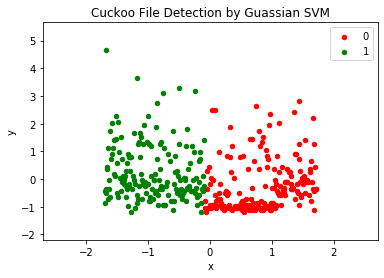

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X,y) #train/test 데이터 세트 분리 

#스케일링은 독립 변수의 공분산 행렬의 조건수를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상  
sc_X = StandardScaler() #평균이 0과 표준편차가 1이 되도록 데이터 표준화시키는 스케일링 함수  

#(1) train/test data의 분포 추정: train/test data를 입력으로 하여 fit 메서드를 실행하면 분포 모수를 객체내에 저장
#(2) train/test data 변환: 각 데이터를 입력으로 하여 transform 메서드를 실행하면 데이터를 변환
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test) 

#SVM을 이용한 분류기 생성
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

clf = SVC(kernel='linear', C = 20) #선형(linear)분류기 생성, C값은 임의로 입력해봄
clf.fit(X_train, y_train) #분류기 학습

y_pred = clf.predict(X_test) #test
cm = confusion_matrix(y_test, y_pred) #test data를 이용한 혼동행렬 생성
accuracy = (cm[0][0]+cm[1][1])/sum(sum(cm)) #정확도 측정: (TP + TN) / (TP + TN + FP + FN)

# Cross validation 교차 검증 
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(clf, X=X_train, y=y_train, cv=10) #데이터를 9:1의 비율로 잘라 train/test 세트 10개 생성

#plot 그리기 
from matplotlib.colors import ListedColormap

plt.figure()
X_set, y_set = X_train, y_train
#좌표행렬 반환하여 plot 바운더리 생성
X1, X2 = np.meshgrid(np.arange(X_set[:,0].min() - 1, 
                               X_set[:,0].max() + 1, 
                               step = 0.01),
                     np.arange(X_set[:,1].min() - 1, 
                               X_set[:,1].max() + 1, 
                               step = 0.01))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i,j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), 
                label = j, s = 20)
    
plt.title('Cuckoo File Detection by Guassian SVM')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [9]:
#test데이터와 예측한 label 값 출력
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
438,0,0
25,1,1
441,0,0
362,0,1
412,0,0
301,0,0
408,0,0
136,1,1
305,0,0
82,1,1


In [10]:
#성능평가
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        64
           1       1.00      0.98      0.99        57

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



In [ ]:
'''
F1 = 2 * (precision * recall) / (precision + recall)
성능이 최고일때 F1 = 1
위 분류기는 0.99점이며, 0과 1 영역에 있는 특징 벡터중 support vector를 각각 64개, 57개 뽑아 학습했음
'''

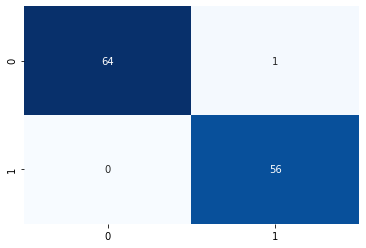

In [15]:
#test한 결과를 confusion matrix로 표현
import seaborn as sns
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

In [ ]:
'''
세로:y_pred, 가로: y_test
실제 0인 파일 64개 중
- 0을 0이라 옳게 판단한것(TP): 64/64
- 0을 1이라 틀리게 판단한것(FP): 0/64

실제 1인 파일 57개 중
- 1을 1이라 옳게 판단한것(TN): 56/57
- 1을 0이라 틀리게 판단한것(FN): 1/57

'''

In [16]:
#에러율 계산
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.008264462809917356
Mean Squared Error: 0.008264462809917356
Root Mean Squared Error: 0.09090909090909091
